# How Many Total Goals are Scored? Predicting the Total Number of Goals scored in a Premier League and EFL Championship Match using Regression Methods

## Part 1: Project Background

#### As an avid fan of statistics, soccer, and prediction, I've always been curious about whether it is possible to predict the total number of goals scored. In this project, I've used different regression methods - Multiple Linear Regression, Lasso Regression, Ridge Regression, K-Nearest Neighbor Regressor, and Random Forest Regressor to predict the total number of goals scored in a game played in the Premier League and EFL Championship. The dataset can be obtained here: https://www.football-data.co.uk/englandm.php

#### The reason I didn't use the classification method (because number of goals scored is a discrete variable... there is no 2.1 goals) is because I wanted to implement the model of choice in predicting the outcome for the U/O 2.5Goals category in soccer betting. I wanted to see if I could predict the total number of goals as precise as possiblt to predict that betting result.

## Part 2: Data Cleaning

In [277]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [196]:
# import data & merge data

# import EFL Championship Data
df1 = pd.read_csv("Championship.csv")

# import Premier League Data
df2 = pd.read_csv("PL.csv")

# Merge two dataframes
frames = [df1, df2]
df = pd.concat(frames)

# Create a new column of 'TG (as in Total Goals)' = 'Full Time Home Goals' + 'Full Time Away Goals'
df['TG'] = df['FTHG'] + df['FTAG']

# (rows, column) numbers of data 
print(df.shape)

(932, 107)


In [169]:
df.head() # observing the first few rows of the dataset

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,TG
0,E1,02/08/2019,19:45,Luton,Middlesbrough,3,3,D,2,2,...,-0.25,1.94,1.96,1.96,1.96,1.98,1.98,1.94,1.93,6
1,E1,03/08/2019,15:00,Barnsley,Fulham,1,0,H,1,0,...,0.25,2.04,1.86,2.05,1.87,2.07,1.88,2.02,1.84,1
2,E1,03/08/2019,15:00,Blackburn,Charlton,1,2,A,0,1,...,-0.75,1.88,2.02,1.91,2.01,1.94,2.02,1.89,1.98,3
3,E1,03/08/2019,15:00,Brentford,Birmingham,0,1,A,0,1,...,-0.50,2.00,1.90,2.01,1.91,2.01,1.96,1.96,1.90,1
4,E1,03/08/2019,15:00,Millwall,Preston,1,0,H,1,0,...,-0.25,2.11,1.79,2.12,1.81,2.13,1.87,2.08,1.80,1


In [170]:
df.isnull().sum()

Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
TG          0
Length: 107, dtype: int64

## Part 3: Exploratory Data Analysis

FTR
A    289
D    241
H    402
Name: FTR, dtype: int64
Home Team Win Percentage: 43.13304721030043
Draw Percentage: 25.858369098712448
Away Team Win Percentage: 31.008583690987123


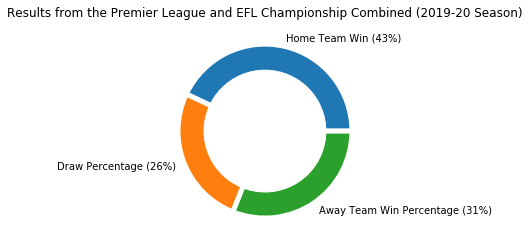

In [197]:
# visualizing the proportion of results from both leagues combined (FTR = Full Time Results)

print(df.groupby('FTR')['FTR'].count())

print("Home Team Win Percentage:", 100*402/(402+241+289))
print("Draw Percentage:", 100*241/(402+241+289))
print("Away Team Win Percentage:", 100*289/(402+241+289))

names='Home Team Win (43%)', 'Draw Percentage (26%)', 'Away Team Win Percentage (31%)' # naming each variable
size=[43, 26, 31]  # creating size for each variable
my_circle=plt.Circle( (0,0), 0.7, color='white') # creating the empty circle in the middle of the doughnut chart
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' }) # creating wedges between the variables
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Results from the Premier League and EFL Championship Combined (2019-20 Season)")
plt.show()

10
count    932.000000
mean       2.672747
std        1.568072
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: TG, dtype: float64


Text(0.5, 1.0, 'Distribution plot of Total Goals Scored, Mean:2.67, Standard Deviation:1.57')

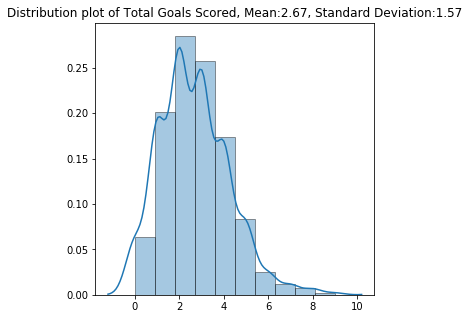

In [198]:
# Visualizing distribution of total number of goals

# number of unique values in 'TG (total goals) column'
print(df.TG.nunique())

print(df.TG.describe())

fig, ax = plt.subplots(figsize=(5,5)) # determine size of plot

# creating a distribution plot with TG column
ax = sns.distplot(df["TG"], bins = 10, hist_kws = dict(edgecolor = "black"))
plt.xlabel("")
plt.title("Distribution plot of Total Goals Scored, Mean:2.67, Standard Deviation:1.57")

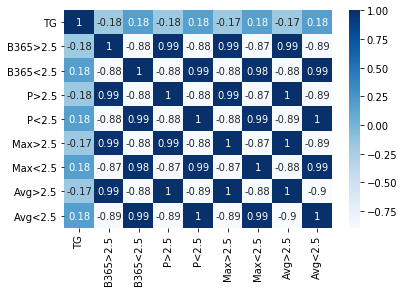

In [250]:
# Correlation Heatmap of the variables of interest

df = df[['TG', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']]

df = df.dropna() # the data had very few missing values that were dropped

corr = df.corr()

df.corr()

sns.heatmap(corr, annot=True, cmap = "Blues")

## Part 4: Model Building and Evaluation

In [202]:
# Defining the Dependent Variable (Y) and Independent Variables (X) 

Y = df['TG']
X = df.drop(['TG'], axis = 1)

# Test/Train Split (20/80 Split)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### Part 4-1: Multiple Linear Regression

In [233]:
# Train/Test Split (80:20) Method
reg = LinearRegression() # building the model
reg.fit(X_train, Y_train) # fitting the model
Y_pred = reg.predict(X_test) # predicting Y values based on X_test data

print("R-squared Value(Train/Test Split):", r2_score(Y_test, Y_pred)) # calculating the R^2 value of the test dataset
print("Test MSE(Train/Test Split):", mean_squared_error(Y_test, Y_pred)) # calculating the mean squared error value (the test MSE)
# --------------------------------------------------------------------------------------------------------------------------------------
# k = 10 fold CV

R2 = cross_val_score(reg, X, Y, scoring = 'r2', cv = 10) # get r-squared value for k = 10 fold CV
mse = cross_val_score(reg, X, Y, scoring = 'neg_mean_squared_error', cv = 10) # get test MSE for k = 10 fold CV

print("R-squared value(k=10 fold CV)", R2.mean())
print("MSE(k=10 fold CV)", -(mse.mean()))


R-squared Value(Train/Test Split): 0.08414641990094796
Test MSE(Train/Test Split): 2.0490878320738264
R-squared value(k=10 fold CV) 0.017579825139642857
MSE(k=10 fold CV) 2.378925804126963


### Part 4-2: Ridge Regression

In [245]:
# Train/Test Split (80:20) Method

# Finding the best parameter, alpha
ridge = Ridge()

parameters = {'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 20, 100, 1000]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 10)

ridge_regressor.fit(X_train, Y_train) # use training data 

# Best parameter
print(ridge_regressor.best_params_)
# Best train MSE value (lowest) using the best parameter
print(-ridge_regressor.best_score_)

# Building the model again with alpha = 100
ridge = Ridge(alpha = 100) # Build model
ridge.fit(X_train, Y_train) # Fit the model using training dataset
Y_pred = ridge.predict(X_test) # Predict on the test dataset

print("R-squared Value(Train/Test Split):", r2_score(Y_test, Y_pred)) # calculating the R^2 value of the test dataset
print("Test MSE(Train/Test Split):", mean_squared_error(Y_test, Y_pred)) # calculating the mean squared error value (the test MSE)

#--------------------------------------------------------------------------------------------------------------------------------------

# k = 10 fold CV

# Finding the best parameter, alpha 
ridge = Ridge()

parameters = {'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 20, 100, 1000]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 10)

ridge_regressor.fit(X, Y) # use whole data

# Best parameter
print(ridge_regressor.best_params_)
# Best MSE (lowest MSE) using the best parameter 
print(-ridge_regressor.best_score_)

ridge= Ridge(alpha = 1)

R2 = cross_val_score(ridge, X, Y, scoring = 'r2', cv = 10) # get r-squared value for k = 10 fold CV

print("R-squared value(k=10 fold CV)", R2.mean())
print("MSE(k=10 fold CV)", -ridge_regressor.best_score_)
print(cross_val_score(ridge, X, Y, scoring = 'neg_mean_squared_error', cv = 10))

{'alpha': 100}
2.462521468166641
R-squared Value(Train/Test Split): 0.06833939612607864
Test MSE(Train/Test Split): 2.0844537254679247
{'alpha': 1}
2.374123831142792
R-squared value(k=10 fold CV) 0.02054739509368798
MSE(k=10 fold CV) 2.374123831142792
[-1.69864572 -2.48876148 -2.4066601  -3.04910162 -2.63632548 -2.99257519
 -2.71743328 -1.61737991 -2.10899607 -2.02535946]


### Part 4-3: Lasso Regression

In [270]:
# Train/Test Split (80:20) Method

# Finding the best parameter, alpha
lasso = Lasso()

parameters = {'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 20, 100, 1000]}

lasso_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 10)

lasso_regressor.fit(X_train, Y_train) # use training data 

# Best parameter
print(lasso_regressor.best_params_)
# Best train MSE value (lowest) using the best parameter
print(-lasso_regressor.best_score_)

# Building the model again with alpha = 100
lasso = Lasso(alpha = 100) # Build model
lasso.fit(X_train, Y_train) # Fit the model using training dataset
Y_pred = lasso.predict(X_test) # Predict on the test dataset

print("R-squared Value(Train/Test Split):", r2_score(Y_test, Y_pred)) # calculating the R^2 value of the test dataset
print("Test MSE(Train/Test Split):", mean_squared_error(Y_test, Y_pred)) # calculating the mean squared error value (the test MSE)

#--------------------------------------------------------------------------------------------------------------------------------------

# k = 10 fold CV

# Finding the best parameter, alpha 
lasso = Lasso()

parameters = {'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1, 10, 20, 100, 1000]}

lasso_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 10)

lasso_regressor.fit(X, Y) # use whole data

# Best parameter
print(lasso_regressor.best_params_)
# Best MSE (lowest MSE) using the best parameter 
print(-lasso_regressor.best_score_)

lasso = Lasso(alpha = 1)

R2 = cross_val_score(lasso, X, Y, scoring = 'r2', cv = 10) # get r-squared value for k = 10 fold CV

print("R-squared value(k=10 fold CV)", R2.mean())
print("MSE(k=10 fold CV)", -lasso_regressor.best_score_)
print(cross_val_score(lasso, X, Y, scoring = 'neg_mean_squared_error', cv = 10))

{'alpha': 100}
2.462521468166641
R-squared Value(Train/Test Split): -5.511798805990509e-05
Test MSE(Train/Test Split): 2.237476402560835
{'alpha': 1}
2.374123831142792
R-squared value(k=10 fold CV) -0.013063487796194772
MSE(k=10 fold CV) 2.374123831142792
[-1.68353618 -2.54595117 -2.54595117 -2.97329017 -2.63920613 -3.13635533
 -2.91786643 -1.66108609 -2.20438292 -2.26488145]


### Part 4-4: K-Nearest Neighbors Regressor

In [254]:
# Here, I used k = sqrt(N), N = observations in training set
# https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e

# Train/Test Split (80:20) Method

neigh = KNeighborsRegressor(n_neighbors = 28) # build model
neigh.fit(X_train, Y_train) # fit model with training data
Y_pred = neigh.predict(X_test) # predict using test data

print("R-squared Value(Train/Test Split):", r2_score(Y_test, Y_pred)) # calculating the R^2 value of the test dataset
print("Test MSE(Train/Test Split):", mean_squared_error(Y_test, Y_pred)) # calculating the mean squared error value (the test MSE)

# k = 10 fold CV

neigh = KNeighborsRegressor(n_neighbors = 28) # build model

R2 = cross_val_score(neigh, X, Y, scoring = 'r2', cv = 10) # get r-squared value for k = 10 fold CV
mse = cross_val_score(neigh, X, Y, scoring = 'neg_mean_squared_error', cv = 10) # get test MSE for k = 10 fold CV

print("R-squared value(k=10 fold CV)", R2.mean())
print("MSE(k=10 fold CV)", -(mse.mean()))

R-squared Value(Train/Test Split): 0.06460355333881818
Test MSE(Train/Test Split): 2.0928121248499396
R-squared value(k=10 fold CV) -0.003377479928338323
MSE(k=10 fold CV) 2.4214908003352336


### Part 4-5: Random Forest Regressor

In [284]:
# Train/Test Split (80:20) Method

rfr = RandomForestRegressor(random_state = 42)

parameters = {'n_estimators':[10, 100, 150, 200, 300]}

CV_rfr = GridSearchCV(rfr, parameters, scoring = 'neg_mean_squared_error', cv = 10)

CV_rfr.fit(X_train, Y_train)

print("Best number of trees(based on training data):", CV_rfr.best_params_)
print("Best MSE value acquired with best number of trees(based on training data):",-CV_rfr.best_score_)

rf = RandomForestRegressor(n_estimators = 200, random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

print("R-squared Value(Train/Test Split):", r2_score(Y_test, Y_pred)) # calculating the R^2 value of the test dataset
print("Test MSE(Train/Test Split):", mean_squared_error(Y_test, Y_pred)) # calculating the mean squared error value (the test MSE)

# k = 10 fold CV

rfr = RandomForestRegressor(random_state = 42)

parameters = {'n_estimators':[10, 100, 150, 200, 300]}

CV_rfr = GridSearchCV(rfr, parameters, scoring = 'neg_mean_squared_error', cv = 10)

CV_rfr.fit(X, Y)

print("Best number of trees(based on whole data):", CV_rfr.best_params_)
print("Best MSE value acquired with best number of trees(based on whole data):",-CV_rfr.best_score_)

rfr_1 = RandomForestRegressor(n_estimators = 200, random_state = 42)

R2 = cross_val_score(rfr_1, X, Y, scoring = 'r2', cv = 10) # get r-squared value for k = 10 fold CV

print("R-squared value(k=10 fold CV)", R2.mean())
print("MSE(k=10 fold CV)", -CV_rfr.best_score_)

Best number of trees(based on training data): {'n_estimators': 200}
Best MSE value acquired with best number of trees(based on training data): 2.9898128929178127
R-squared Value(Train/Test Split): 0.04631335816838977
Test MSE(Train/Test Split): 2.133733749424391
Best number of trees(based on whole data): {'n_estimators': 200}
Best MSE value acquired with best number of trees(based on whole data): 2.663251750094419
R-squared value(k=10 fold CV) -0.11661917184291548
MSE(k=10 fold CV) 2.663251750094419


### Part 4-6: Model Comparison (based on test-MSE and an observation into R^2 values)

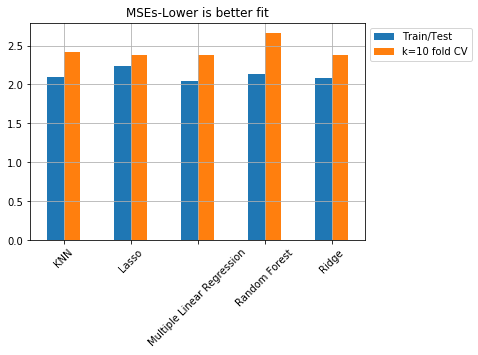

In [295]:
# Test-MSEs (train/test split) and MSEs (k = 10 fold CV)

# MSEs- Rounded to the fourth decimal-Multiple Linear Regression had best results
data = {'Model Name': ['Multiple Linear Regression', 'Multiple Linear Regression','Ridge', 'Ridge', 'Lasso', 'Lasso', 'KNN', 'KNN',
                       'Random Forest', 'Random Forest'],
        'MSE': [2.0491, 2.3790 ,2.0845 ,2.3741 , 2.2375, 2.3741 , 2.0928, 2.4215 , 2.1337, 2.6633 ],
       'Type': ['Train/Test', 'k=10 fold CV', 'Train/Test', 'k=10 fold CV', 'Train/Test', 'k=10 fold CV', 'Train/Test', 
                'k=10 fold CV', 'Train/Test', 'k=10 fold CV']}

df = pd.DataFrame(data, columns = ['Model Name', 'MSE', 'Type'])

df.pivot("Model Name", "Type", "MSE").plot(kind='bar')

plt.xlabel("")
plt.legend(title = "", bbox_to_anchor = (1,1))
plt.xticks(rotation=45)
plt.title("MSEs-Lower is better fit")
plt.grid()
plt.show()

# Based on Train/Test split, Multiple Linear Regression was best model!
# However, based on k = 10 fold CV, Ridge and Lasso tie as the best model

## Part 5: Things that I've Learned and Things worth looking into further

#### - Different regression methods and searching for the best parameters for certain models (Lasso, Ridge(alpha values), Random Forest(number of trees), etc.)
#### - Distribution of the dataset
#### - Negative R-squared values -> worth looking into the reason why I had such results
#### - Why did some models perform better than others?
#### - If this was a classification problem (on predicting total number of goals scored) would the results have been any different?

## Part 6: Resources that I've Used to Learn and Complete the Project

#### Resources)
#### -(Dataset)https://www.football-data.co.uk/englandm.php
#### -(Decision Trees vs Random Forest) https://stats.stackexchange.com/questions/285834/difference-between-random-forests-and-decision-tree
#### -(Decision Trees vs Random Forest) https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991
#### -(Example of using GridsearchCV(tuning parameters)-KNN) https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657
#### -(Example of using GridsearchCV(tuning parameters)-Lasso,Ridge-CV) https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
#### -(R^2 as a way to compare models for best-fit?) https://data.library.virginia.edu/is-r-squared-useless/
#### -(Ways to measure best fit for regression models) https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/
#### -(The scoring parameter: defining model evaluation rules in cross_val_score) https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#### -(low R squared values aren't always bad->R squared may be lower for values harder to predict) https://statisticsbyjim.com/regression/interpret-r-squared-regression/
#### -(low and high alpha values on ridge regression) https://stackoverflow.com/questions/59706137/what-is-alpha-in-ridge-regression#:~:text=If%20Alpha%20is%20close%20to,and%20better%20generalize%20the%20coefficients.
#### -(example of ridge and lasso regression in Python)https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn
#### -(GridSearchCV with test/train data-KNN)https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec
#### -(what a negative R-squared value implies)https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative
#### -***(random forest using gridsearchCV)https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv
#### -***(Lasso, Ridge)https://github.com/krishnaik06/RegressionandLasso/blob/master/Lassoand%20Regression.ipynb


